In [6]:
## necessary packages

using Distributions
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using Random
using SpecialFunctions # Matern functions
using MLBase         # cross-validation 
using Convex         # compute stacking weights
using MosekTools     # compute stacking weights
using RCall
include("./utils.jl")

sp_stacking_K_fold_MT (generic function with 1 method)

In [7]:
# Set the parameters of the simulated data #
N_ls = [200, 300, 400, 500, 600, 700, 800, 900];
N_ho = 100;
seed = 1;
time_compar = Array{Float64, 3}(undef, length(N_ls), 3, 2);

In [8]:
## candidate values of hyperparameters for stacking ##
p = 2
deltasq_grid = [0.1, 0.5, 1, 2];
phi_grid = [3, 9, 15, 21];
nu_grid = [0.5, 1, 1.5, 1.75];
## priors parameters ##
Priors = Dict("μβ" => fill(0.0, p), "inv_V_β" => Diagonal(ones(p) * 0.25), 
    "aσ" => 2.0, "bσ" => 2.0);
K_fold = 10;

In [9]:
for sim_id in 1:2
    print("\n", "simulation: ", sim_id, "\n");
    if sim_id == 1
        p = 2;      # No. covariates
        β = [1.0 2.0]; #regression coeff
        σ2 = 1.0; ϕ = 7.0; ν = 1.0; τ2 = 1.0; # hyperparmeters in matern
    else
        p = 2;      # No. covariates
        β = [1.0 2.0]; #regression coeff
        σ2 = 1.0; ϕ = 20.0; ν = 0.5; τ2 = 0.3; # hyperparmeters in matern
    end
    for i in 1:length(N_ls)
        print("dataset: ", i, "\n")
        
        # generate simulation data #
        
        Random.seed!(i);
        N = N_ls[i];             # No. all positions
        ind_mod = 1:(N - N_ho);      # index of training observations
        coords = rand(2, N);         # random location over unit square (2 by N)
        X = vcat(fill(1.0, (1, N)), rand(Normal(), (1, N)));          # design matrix (p by N)
        D = pairwise(Euclidean(), coords, dims = 2);                  # distance matrix
        Cov = Symmetric(Maternlu.(UpperTriangular(D), 
                ν = ν, ϕ = ϕ, σ2 = σ2))                               # covariance matrix
        z = rand(MvNormal(Cov), 1);                                   # latent process
        y = (β * X)[1,:] + z[:,1] + sqrt(τ2) * rand(Normal(), N);     # response

        ## fit stacking ##
        # need to compile the function first to obtain precise time estimation #
        if sim_id == 1 & i == 1 
            time_compar[i, 1, sim_id] = @elapsed sp_stacking_K_fold_MT(X[:, ind_mod], y[ind_mod], coords[:, ind_mod], 
                deltasq_grid, phi_grid, nu_grid, Priors, K_fold = K_fold, 
                seed = seed, label = "LSE");
            time_compar[i, 2, sim_id] = @elapsed sp_stacking_K_fold_MT(X[:, ind_mod], y[ind_mod], coords[:, ind_mod], 
                deltasq_grid, phi_grid, nu_grid, Priors, K_fold = K_fold, 
                seed = seed, label = "LP");
        end

        time_compar[i, 1, sim_id] = @elapsed sp_stacking_K_fold_MT(X[:, ind_mod], y[ind_mod], coords[:, ind_mod], 
            deltasq_grid, phi_grid, nu_grid, Priors, K_fold = K_fold, 
            seed = seed, label = "LSE");

        time_compar[i, 2, sim_id] = @elapsed sp_stacking_K_fold_MT(X[:, ind_mod], y[ind_mod], coords[:, ind_mod], 
            deltasq_grid, phi_grid, nu_grid, Priors, K_fold = K_fold, 
            seed = seed, label = "LP");
        
        ## fit MCMC ##
        inv_V_beta = Priors["inv_V_β"]
        @rput X
        @rput y
        @rput ind_mod
        @rput coords
        @rput inv_V_beta
        
        R"""

        library(spBayes)
        library(ggplot2)
        library(geoR)

        X = t(X);
        coords = t(coords);

        n.samples <- 20000
        starting <- list("phi"=3/0.5, "sigma.sq"=1, "tau.sq"=1, "nu" = 0.5)
        tuning <- list("phi"=0.1, "sigma.sq"=0.1, "tau.sq"=0.1, "nu" = 0.1)
        priors.1 <- list("beta.Norm"=list(rep(0, ncol(X)), solve(inv_V_beta)),
                       "phi.Unif"=c(3, 21), "sigma.sq.IG"=c(2, 2),
                       "tau.sq.IG"=c(2, 2), "nu.unif" = c(0.25, 2))

        cov.model <- "matern"
        n.report <- 5000
        verbose <- TRUE
        m.1 <- spLM(y[ind_mod]~X[ind_mod, ]-1, coords=coords[ind_mod, ],
                  starting=starting,
                  tuning=tuning, priors=priors.1, cov.model=cov.model,
                  n.samples=n.samples, verbose=verbose, n.report=n.report)

        MCMC_t <- m.1$run.time[3]

        """
        @rget MCMC_t
        
        time_compar[i, 3, sim_id] = MCMC_t
    end  
end


simulation: 1
dataset: 1
----------------------------------------
	General model description
----------------------------------------
Model fit with 100 observations.

Number of covariates 2 (including intercept if specified).

Using the matern spatial correlation model.

Number of MCMC samples 200.

Priors and hyperpriors:
	beta normal:
	mu:	0.000	0.000	
	cov:
	4.000	0.000	
	0.000	4.000	

	sigma.sq IG hyperpriors shape=2.00000 and scale=2.00000
	tau.sq IG hyperpriors shape=2.00000 and scale=2.00000
	phi Unif hyperpriors a=3.00000 and b=21.00000
	nu Unif hyperpriors a=0.25000 and b=2.00000
-------------------------------------------------
		Sampling
-------------------------------------------------
Sampled: 50 of 200, 25.00%
Report interval Metrop. Acceptance rate: 42.00%
Overall Metrop. Acceptance rate: 42.00%
-------------------------------------------------


┌ Warning: RCall.jl: --------------------------------------------------------------
│  Analysis of Geostatistical Data
│  For an Introduction to geoR go to http://www.leg.ufpr.br/geoR
│  geoR version 1.8-1 (built on 2020-02-08) is now loaded
│ --------------------------------------------------------------
│ 
└ @ RCall /home/luzhang/.julia/packages/RCall/6kphM/src/io.jl:172


Sampled: 100 of 200, 50.00%
Report interval Metrop. Acceptance rate: 34.00%
Overall Metrop. Acceptance rate: 38.00%
-------------------------------------------------
Sampled: 150 of 200, 75.00%
Report interval Metrop. Acceptance rate: 54.00%
Overall Metrop. Acceptance rate: 43.33%
-------------------------------------------------
Sampled: 200 of 200, 100.00%
Report interval Metrop. Acceptance rate: 48.00%
Overall Metrop. Acceptance rate: 44.50%
-------------------------------------------------
dataset: 2
----------------------------------------
	General model description
----------------------------------------
Model fit with 200 observations.

Number of covariates 2 (including intercept if specified).

Using the matern spatial correlation model.

Number of MCMC samples 200.

Priors and hyperpriors:
	beta normal:
	mu:	0.000	0.000	
	cov:
	4.000	0.000	
	0.000	4.000	

	sigma.sq IG hyperpriors shape=2.00000 and scale=2.00000
	tau.sq IG hyperpriors shape=2.00000 and scale=2.00000
	phi Unif 

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/luzhang/.julia/packages/Convex/uI27T/src/solution.jl:263


MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(113) of matrix 'A'.
----------------------------------------
	General model description
----------------------------------------
Model fit with 300 observations.

Number of covariates 2 (including intercept if specified).

Using the matern spatial correlation model.

Number of MCMC samples 200.

Priors and hyperpriors:
	beta normal:
	mu:	0.000	0.000	
	cov:
	4.000	0.000	
	0.000	4.000	

	sigma.sq IG hyperpriors shape=2.00000 and scale=2.00000
	tau.sq IG hyperpriors shape=2.00000 and scale=2.00000
	phi Unif hyperpriors a=3.00000 and b=21.00000
	nu Unif hyperpriors a=0.25000 and b=2.00000
-------------------------------------------------
		Sampling
-------------------------------------------------


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/luzhang/.julia/packages/Convex/uI27T/src/solution.jl:263


Sampled: 50 of 200, 25.00%
Report interval Metrop. Acceptance rate: 26.00%
Overall Metrop. Acceptance rate: 26.00%
-------------------------------------------------
Sampled: 100 of 200, 50.00%
Report interval Metrop. Acceptance rate: 18.00%
Overall Metrop. Acceptance rate: 22.00%
-------------------------------------------------
Sampled: 150 of 200, 75.00%
Report interval Metrop. Acceptance rate: 22.00%
Overall Metrop. Acceptance rate: 22.00%
-------------------------------------------------
Sampled: 200 of 200, 100.00%
Report interval Metrop. Acceptance rate: 16.00%
Overall Metrop. Acceptance rate: 20.50%
-------------------------------------------------
dataset: 4
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(245) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(299) of matrix 'A'.
----------------------------------------
	General model description
----------------------------------------
Model fit with 400 obser

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/luzhang/.julia/packages/Convex/uI27T/src/solution.jl:263


----------------------------------------
	General model description
----------------------------------------
Model fit with 600 observations.

Number of covariates 2 (including intercept if specified).

Using the matern spatial correlation model.

Number of MCMC samples 200.

Priors and hyperpriors:
	beta normal:
	mu:	0.000	0.000	
	cov:
	4.000	0.000	
	0.000	4.000	

	sigma.sq IG hyperpriors shape=2.00000 and scale=2.00000
	tau.sq IG hyperpriors shape=2.00000 and scale=2.00000
	phi Unif hyperpriors a=3.00000 and b=21.00000
	nu Unif hyperpriors a=0.25000 and b=2.00000
-------------------------------------------------
		Sampling
-------------------------------------------------
Sampled: 50 of 200, 25.00%
Report interval Metrop. Acceptance rate: 20.00%
Overall Metrop. Acceptance rate: 20.00%
-------------------------------------------------
Sampled: 100 of 200, 50.00%
Report interval Metrop. Acceptance rate: 8.00%
Overall Metrop. Acceptance rate: 14.00%
-------------------------------------

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/luzhang/.julia/packages/Convex/uI27T/src/solution.jl:263


----------------------------------------
	General model description
----------------------------------------
Model fit with 800 observations.

Number of covariates 2 (including intercept if specified).

Using the matern spatial correlation model.

Number of MCMC samples 200.

Priors and hyperpriors:
	beta normal:
	mu:	0.000	0.000	
	cov:
	4.000	0.000	
	0.000	4.000	

	sigma.sq IG hyperpriors shape=2.00000 and scale=2.00000
	tau.sq IG hyperpriors shape=2.00000 and scale=2.00000
	phi Unif hyperpriors a=3.00000 and b=21.00000
	nu Unif hyperpriors a=0.25000 and b=2.00000
-------------------------------------------------
		Sampling
-------------------------------------------------
Sampled: 50 of 200, 25.00%
Report interval Metrop. Acceptance rate: 26.00%
Overall Metrop. Acceptance rate: 26.00%
-------------------------------------------------
Sampled: 100 of 200, 50.00%
Report interval Metrop. Acceptance rate: 4.00%
Overall Metrop. Acceptance rate: 15.00%
-------------------------------------

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/luzhang/.julia/packages/Convex/uI27T/src/solution.jl:263


Overall Metrop. Acceptance rate: 30.00%
-------------------------------------------------
Sampled: 100 of 200, 50.00%
Report interval Metrop. Acceptance rate: 28.00%
Overall Metrop. Acceptance rate: 29.00%
-------------------------------------------------
Sampled: 150 of 200, 75.00%
Report interval Metrop. Acceptance rate: 8.00%
Overall Metrop. Acceptance rate: 22.00%
-------------------------------------------------
Sampled: 200 of 200, 100.00%
Report interval Metrop. Acceptance rate: 28.00%
Overall Metrop. Acceptance rate: 23.50%
-------------------------------------------------
dataset: 4
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(245) of matrix 'A'.
----------------------------------------
	General model description
----------------------------------------
Model fit with 400 observations.

Number of covariates 2 (including intercept if specified).

Using the matern spatial correlation model.

Number of MCMC samples 200.

Priors and hyperpriors:
	bet

In [10]:
time_compar[:, :, :]

8×3×2 Array{Float64, 3}:
[:, :, 1] =
  0.115546   0.189411   0.89
  0.592299   0.535792   4.087
  1.43768    1.46611    9.158
  2.79706    2.57988   15.951
  3.64341    4.04896   16.605
  6.16846    6.07041   22.002
  7.59486    8.92803   29.737
 10.2175    11.2326    32.959

[:, :, 2] =
  0.197357   0.213973   0.671
  0.630916   0.854236   3.962
  1.59973    1.81592    9.776
  2.26991    2.88726   15.62
  4.15269    3.92373   18.357
  5.64071    6.0378    28.47
  7.00114    8.67851   32.182
 10.4591    11.3707    33.511

In [24]:
@save "../results/time_compar.jld" N_ls N_ho time_compar

In [25]:
## plot the comparision ##
@load "../results/time_compar.jld" N_ls N_ho time_compar

3-element Vector{Symbol}:
 :N_ls
 :N_ho
 :time_compar

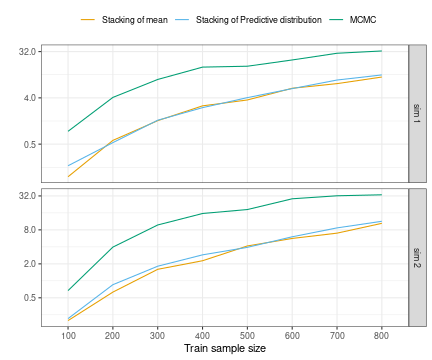

[1] 12


RObject{StrSxp}
[1] "../pics/time_compar.png"


In [26]:
@rput time_compar
@rput N_ls
@rput N_ho
R"""
library(ggplot2)
library(parallel)
print(detectCores())
time_dta <- data.frame(time = c(time_compar), 
                N_train = rep(paste(N_ls - N_ho), 3*2), 
                sim = rep(c(1, 2), each = length(N_ls)*3),
                type = rep(rep(c(1:3), each = length(N_ls)), 2))

sim_label = c("sim 1", "sim 2")              
time_dta$sim = factor(time_dta$sim, levels = 1:2, labels = sim_label)
type_label = c("stacking of means", "stacking of predictive densities", "MCMC")              
time_dta$type = factor(time_dta$type, levels = 1:3, labels = type_label)                          


p_summary <- ggplot(time_dta, aes(x = N_train, y = time, color = label)) +
  geom_line(aes(x = N_train, y = time, group = type, color = type)) + 
  theme_bw() + xlab("Train sample size") + 
  facet_wrap(~ sim, ncol = 1, scales = "free_y", strip.position="right") +
  theme(legend.position="top", legend.title = element_blank()) + ylab(" ") +
  scale_y_continuous(trans='log2') + 
  scale_colour_manual(values=c("#E69F00", "#56B4E9", "#009E73")) 
  
print(p_summary)

#plot(N_ls - 100, time_compar[, 1, 1])

ggsave(paste0("../pics/time_compar.png"), 
       plot = p_summary, 
       width = 6.5, height = 4.0, units = "in", dpi = 600)
       
"""